In [1]:
from visualization_utils import *
import numpy as np
import torch

In [2]:
first = InterpretationData("3axo4ws5")
data_loader = first.data_loader
ids = {
    "f-gumbel_softmax_soft-reconst2-theta0-GAE": ["3axo4ws5","1jgc65uk", "e1cov84y"],
    "f-gumbel_softmax_soft-reconst2-theta1": ["taef1i2o", "n56dcbjz", "cz5sgw3x"],
    "f-softmax-reconst2-theta1": ["oliyqarb", "96daw4mj", "77k8iic3"],
    "f-gumbel_softmax_hard-reconst2-theta1": ["spkueih6", "vg1vt7x5", "lsg80m8a"],
    "f-gumbel_softmax_soft-reconst0-theta1": ["cpittv2f", "afuouzh1", "d7gob1eg"],
    "f-noact-reconst0-theta0": ["mg2s4zbs", "8owphyct", "dd3jvdka"],
    "f-gumbel_softmax_soft-reconst2-theta0": ["k7wavqf0", "5uewb91h", "u33pgenq"]
}
ids = {
    "f-gumbel_softmax_soft-reconst0-theta0": ["15xx99a9", "27w9ceih", "1vjnkcju"]
}
#gumbel_theta0_reconst1 = InterpretationData("m4038aou", data_loader)

0it [00:00, ?it/s]


Accuracy: 92.67%


In [51]:
baseline = InterpretationData("mg2s4zbs")
data_loader = baseline.data_loader
models = {
    "baseline": baseline,
    "full": InterpretationData("taef1i2o", data_loader),
    "no_reconst": InterpretationData("cpittv2f", data_loader),
    "no_theta": InterpretationData("k7wavqf0", data_loader),
    "no_losses": InterpretationData("1vjnkcju", data_loader),
    "softmax": InterpretationData("oliyqarb", data_loader),
    "hard": InterpretationData("spkueih6", data_loader)
}

0it [00:00, ?it/s]


Accuracy: 99.33%


0it [00:00, ?it/s]


Accuracy: 84.67%


0it [00:00, ?it/s]


Accuracy: 89.67%


0it [00:00, ?it/s]


Accuracy: 87.33%


0it [00:00, ?it/s]


Accuracy: 95.67%


0it [00:00, ?it/s]
C:\Users\jonas\AppData\Local\Temp\jonas_pyg\tmpv1nhbm_0.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.module_5(x)


Accuracy: 94.33%


0it [00:00, ?it/s]


Accuracy: 83.67%


In [22]:
entropies = np.zeros((len(ids), 3))
for i, (name, id_list) in enumerate(ids.items()):
    for j, wandb_name in enumerate(id_list):
        entropies[i, j] = InterpretationData(wandb_name).calculate_average_activation_shannon_entropy().item()
    print(f"{name}: {np.mean(entropies[i]):.4f} +- {np.std(entropies[i]):.4f}")


0it [00:00, ?it/s]


Accuracy: 85.00%


0it [00:00, ?it/s]


Accuracy: 93.33%


0it [00:00, ?it/s]


Accuracy: 95.33%
f-gumbel_softmax_soft-reconst0-theta0: 0.3758 +- 0.1914


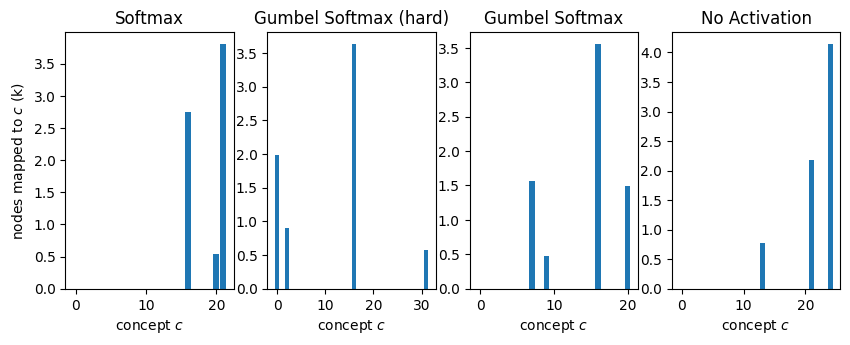

In [73]:
import matplotlib.pyplot as plt
my_models = {"softmax": "Softmax", "hard": "Gumbel Softmax (hard)", "full": "Gumbel Softmax", "baseline": "No Activation"}
fig, axes = plt.subplots(1, len(my_models), figsize=(10, 5/1.5))
axes[0].set_ylabel("nodes mapped to $c$ (k)")
for i, m in enumerate(my_models.keys()):
    counts = np.bincount(np.argmax(models[m].x_out_all, axis=1)) / 1000
    axes[i].bar(np.arange(counts.shape[0]), counts)
    axes[i].set_xlabel("concept $c$")
    axes[i].set_title(my_models[m])
fig.savefig("vis/concept_counts.pdf", bbox_inches='tight')

baseline
full
no_reconst
no_theta
no_losses
softmax
hard


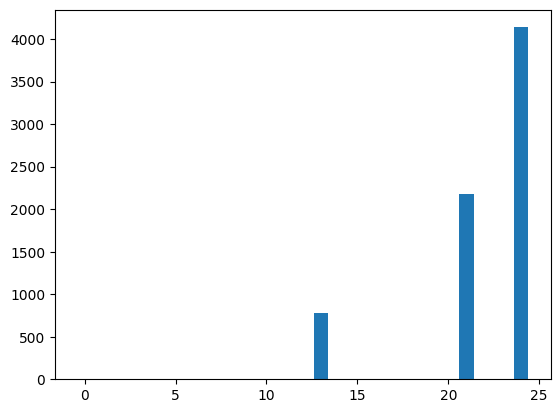

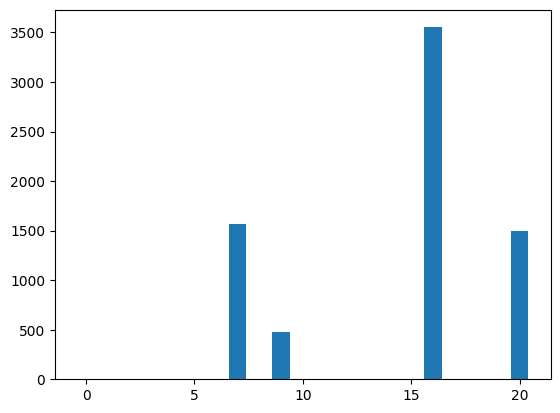

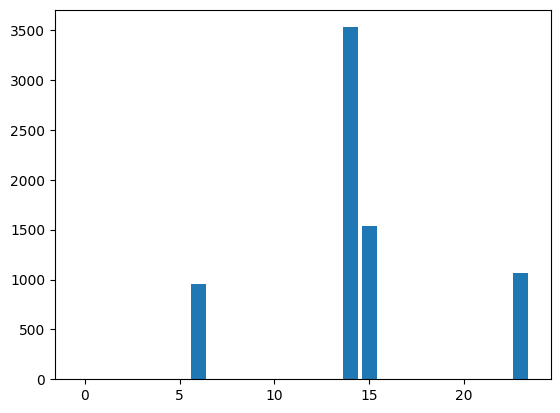

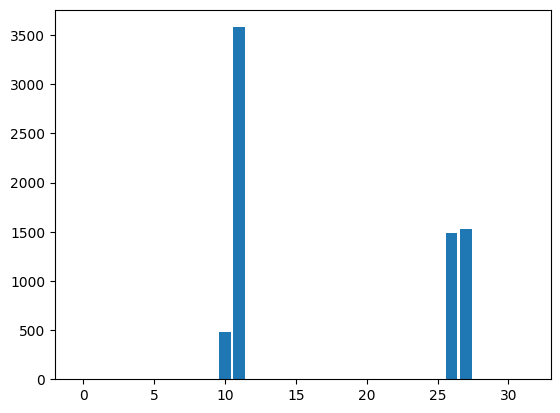

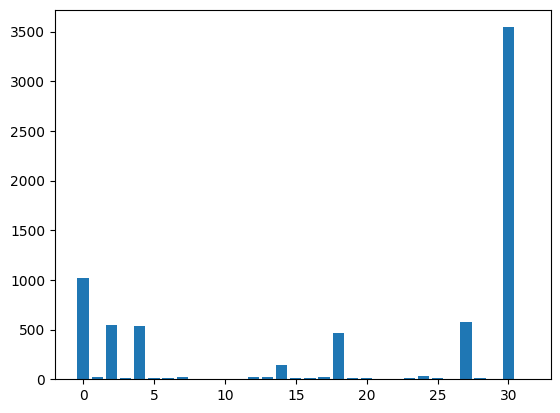

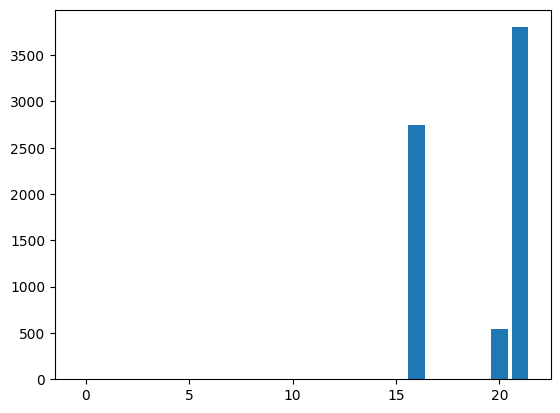

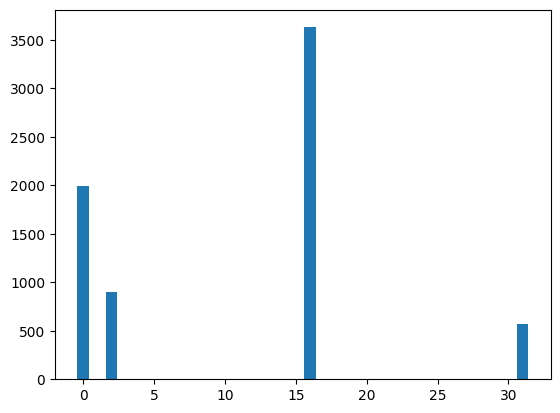

In [62]:
for name, model in models.items():
    print(name)
    #_ = model.plot_category_histogram()



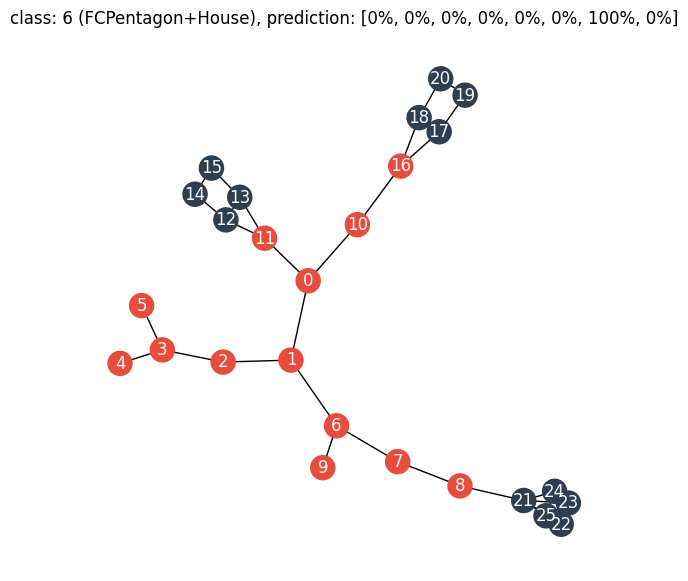

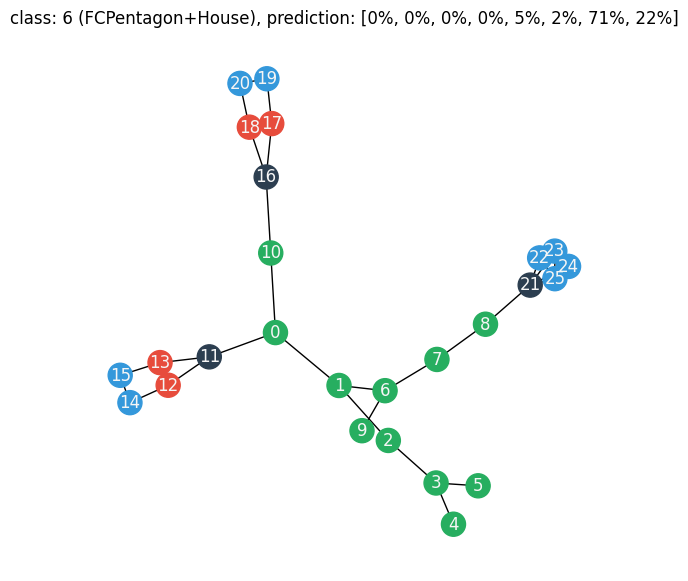

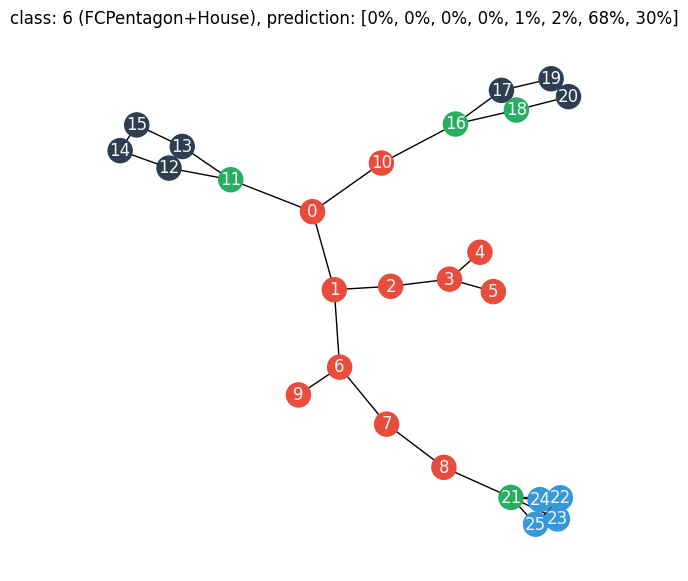

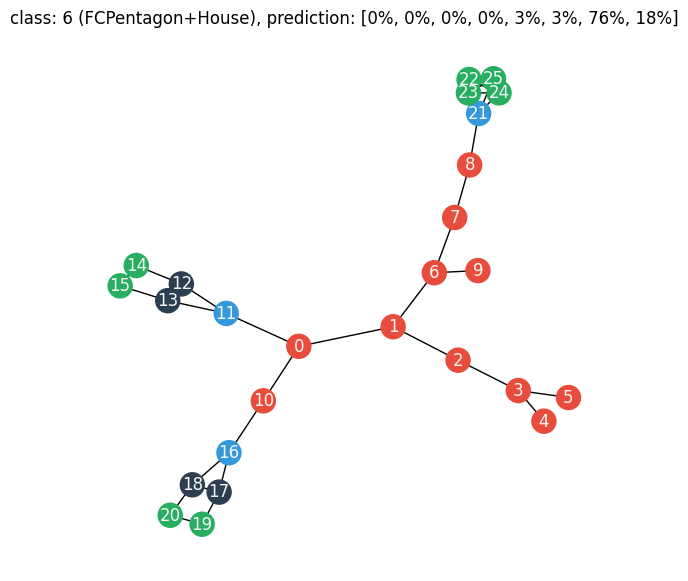

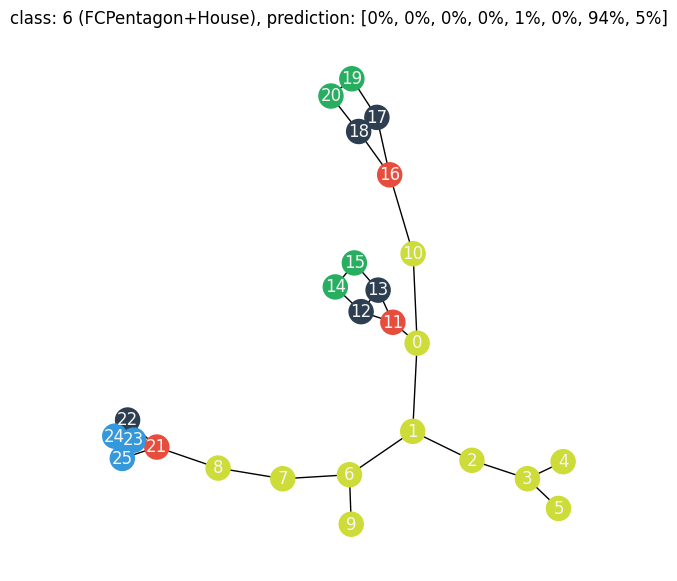

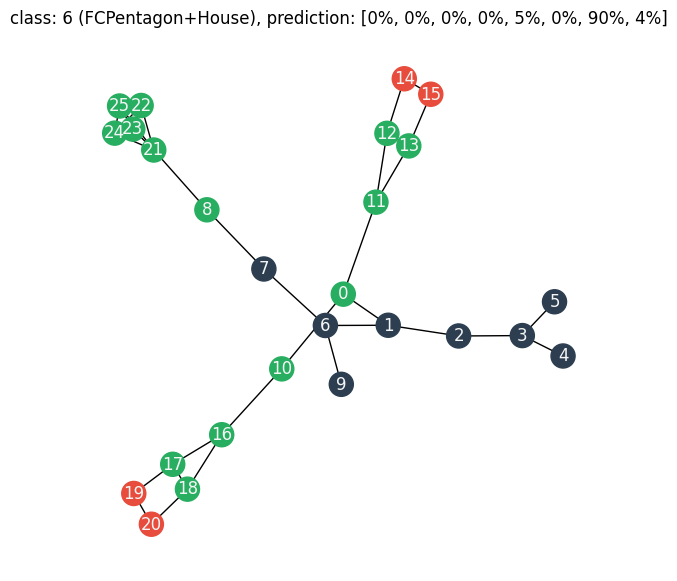

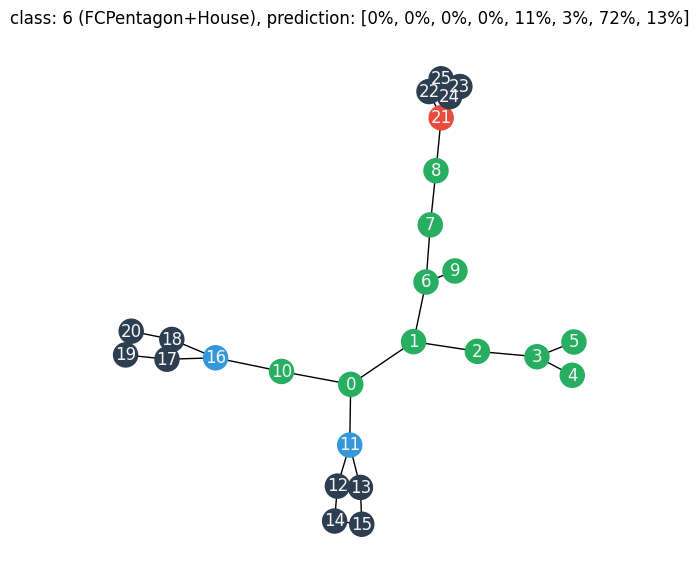

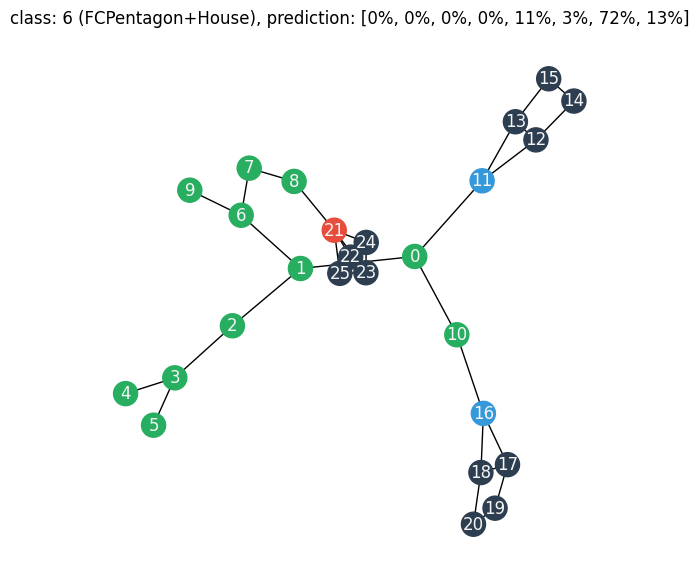

In [25]:
sample = 2
for name, model in models.items():
    # print(f"{name}: {model.calculate_average_activation_shannon_entropy().item():.2f}")
    _ = model.draw_graph(sample, True)
_ = model.draw_graph(sample, "vis/graph.pdf")

In [6]:
xs = [np.round(m.x_out_all[m.batch_all == 1], decimals=2) for m in models]

AttributeError: 'str' object has no attribute 'x_out_all'

baseline
full
no_reconst
no_theta
no_losses
softmax
hard


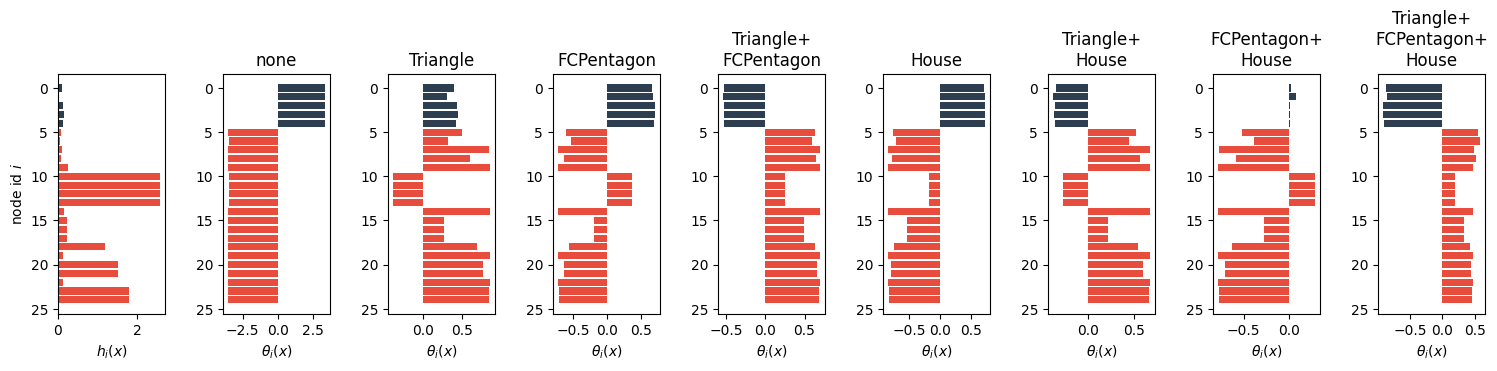

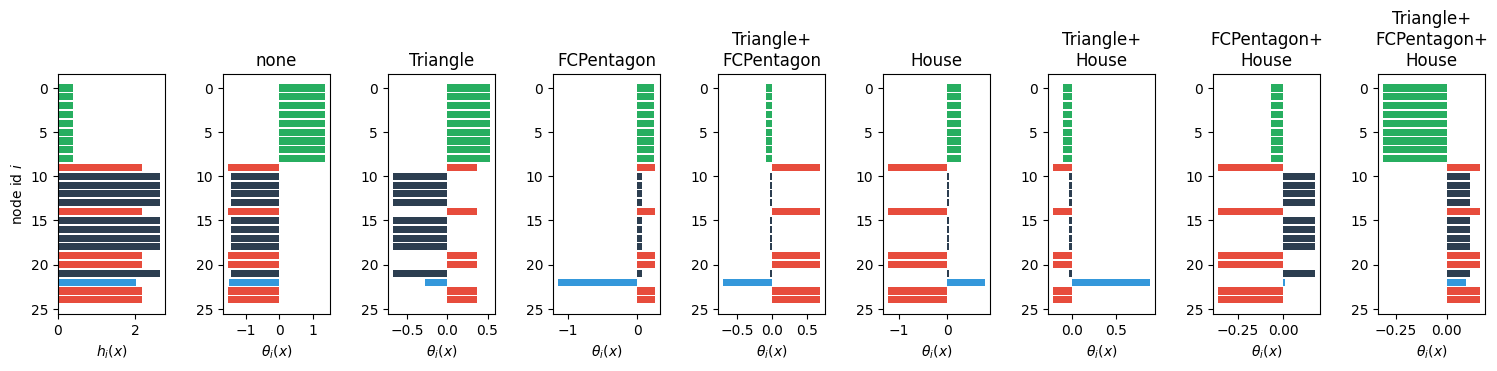

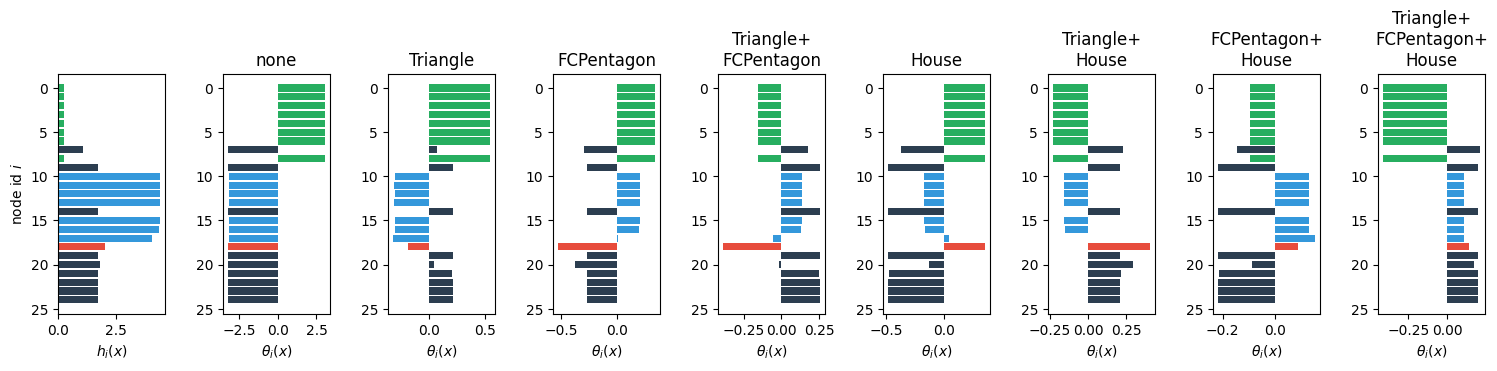

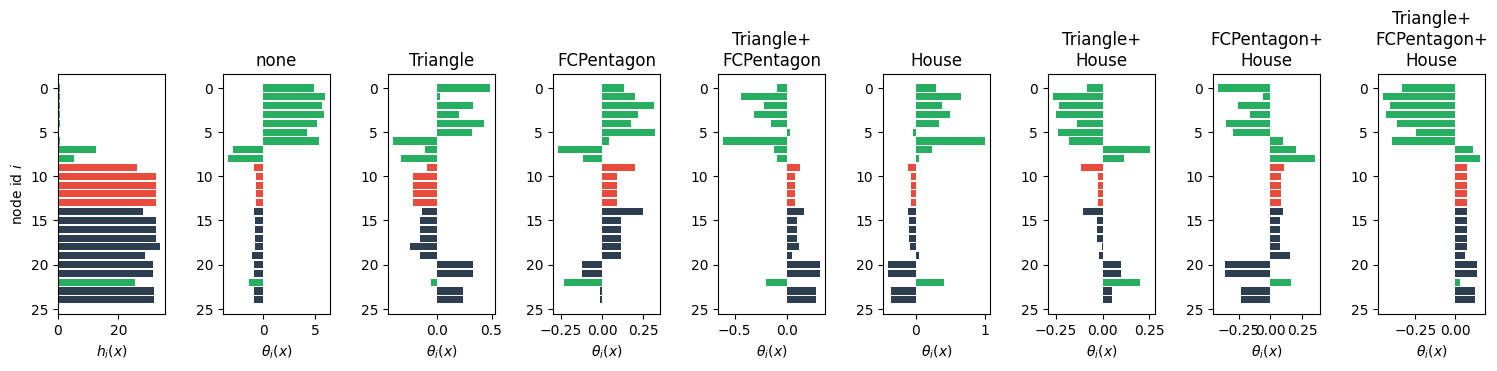

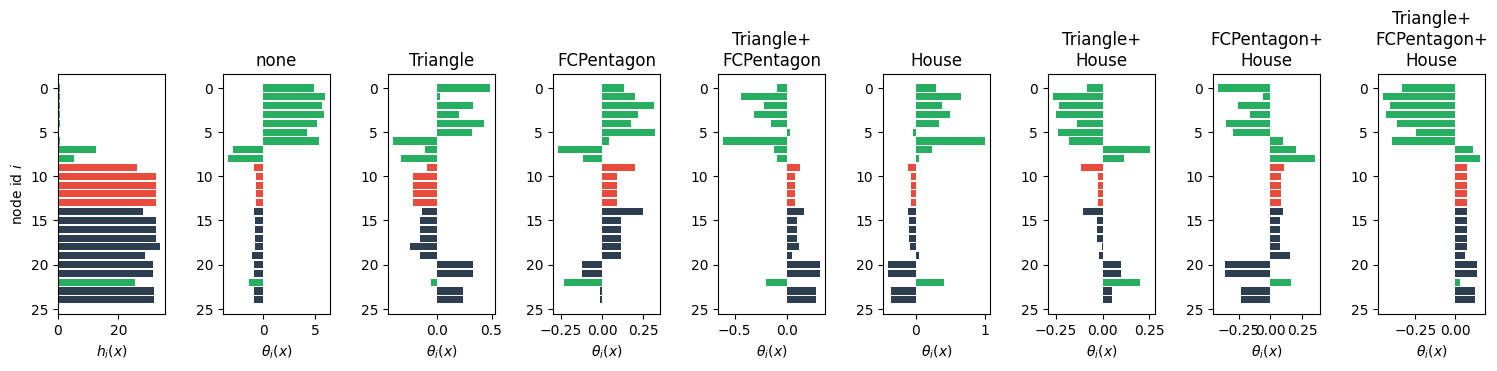

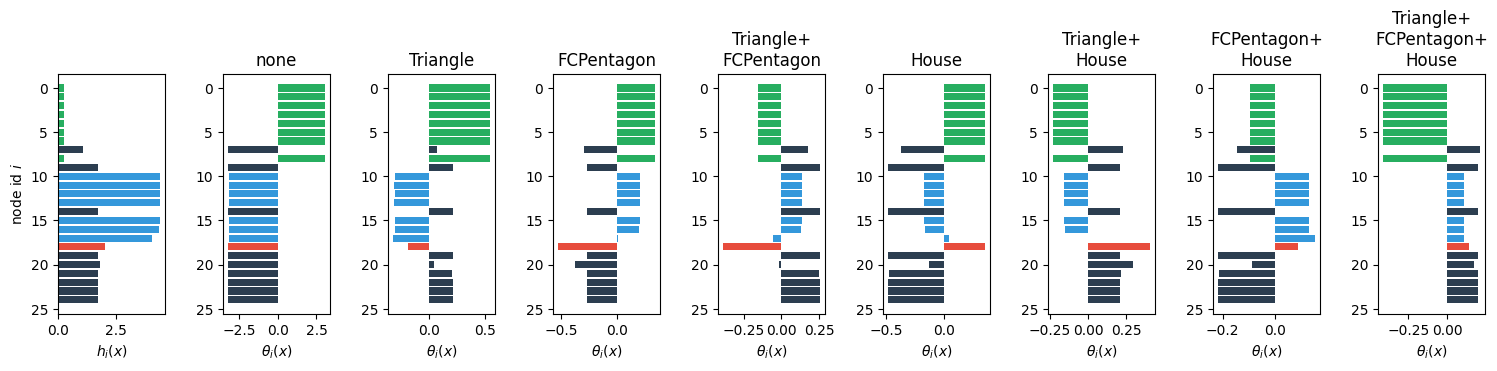

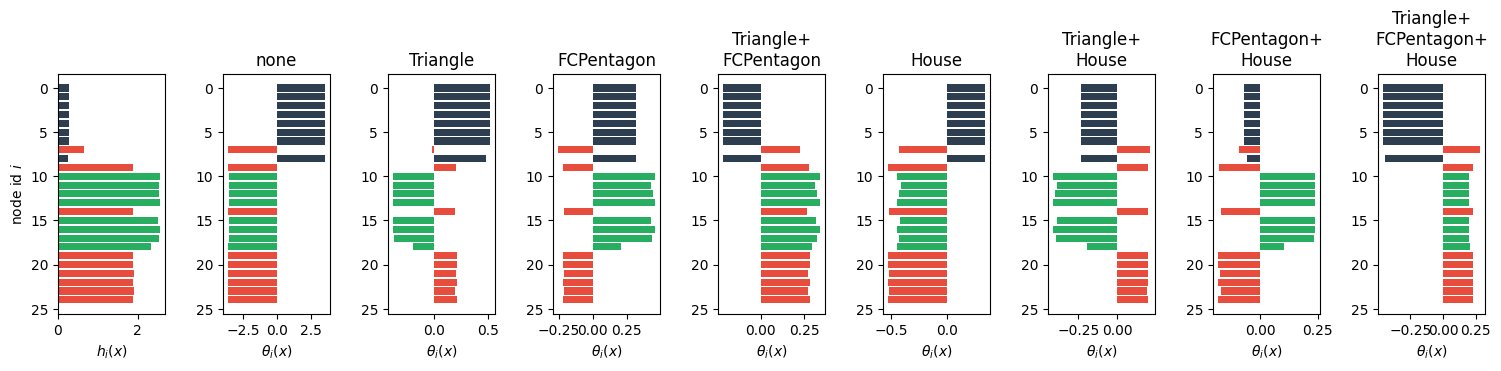

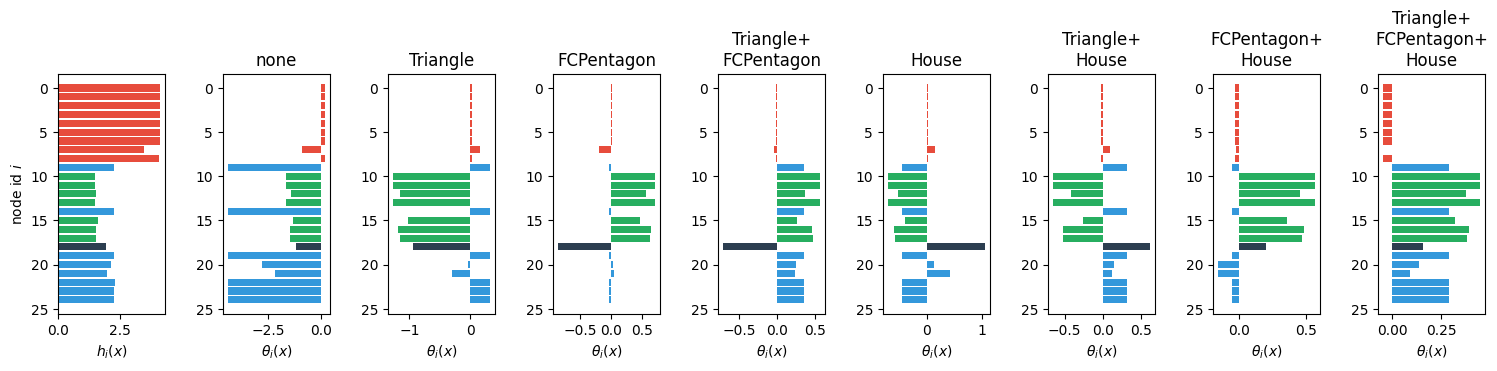

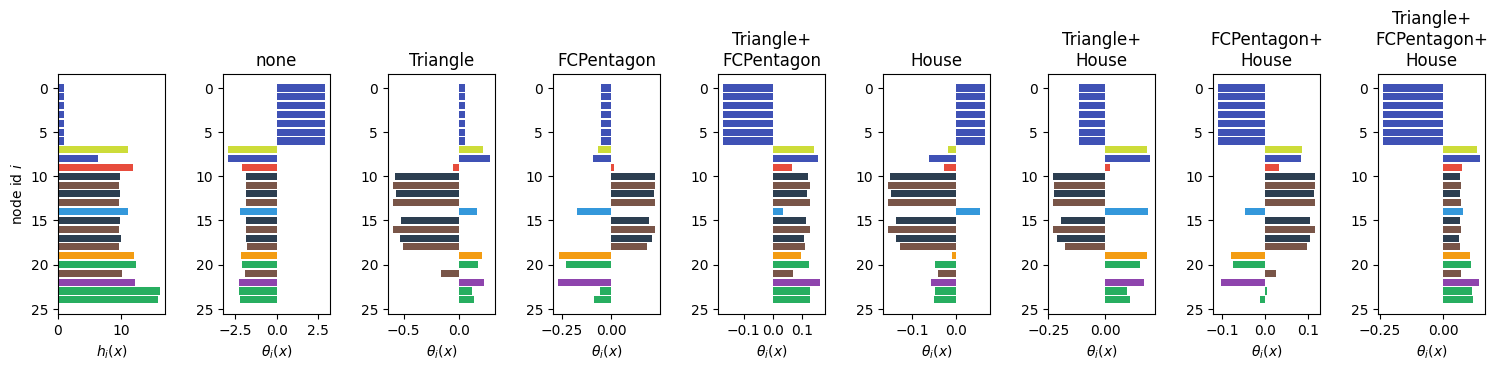

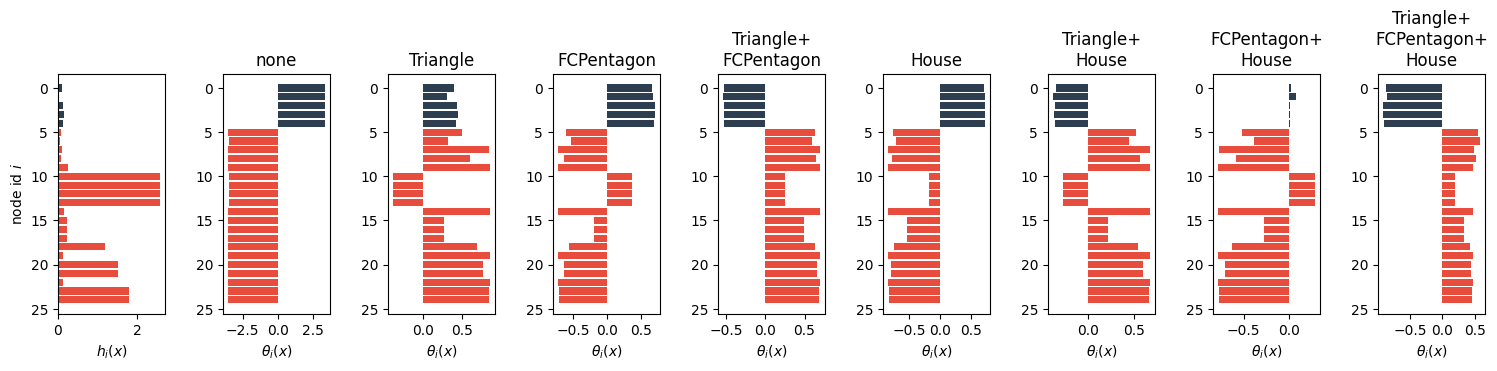

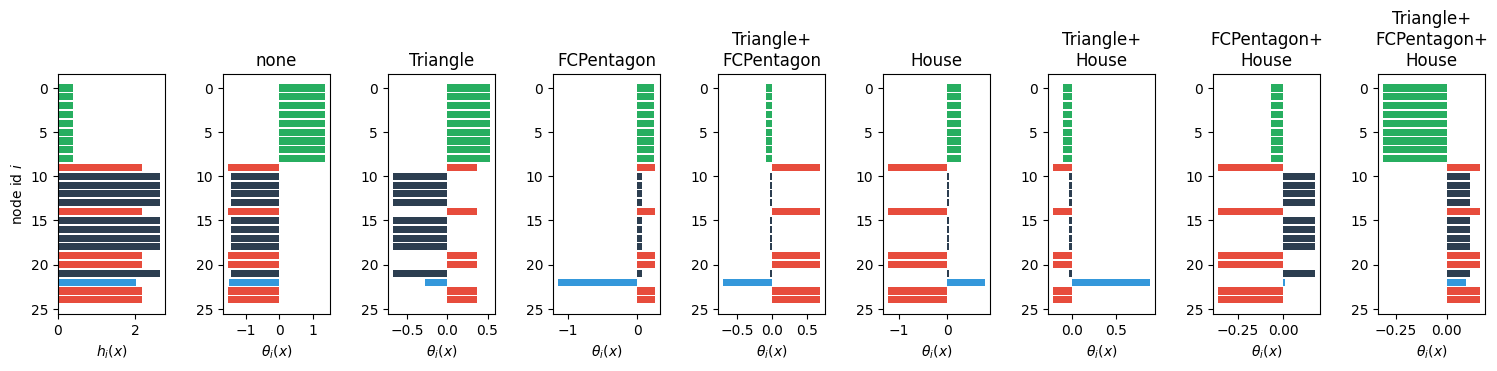

In [63]:
models["softmax"].plot_theta_and_h(3, True, save_path="vis/h_theta_softmax.pdf")
models["hard"].plot_theta_and_h(3, True, save_path="vis/h_theta_hard.pdf")
models["full"].plot_theta_and_h(3, True, save_path="vis/h_theta_ours.pdf")
models["baseline"].plot_theta_and_h(3, True, save_path="vis/h_theta_no_loss_no_reg.pdf.pdf")
for name, model in models.items():
    print(name)
    #_ = model.plot_theta_and_h(sample, False)
    _ = model.plot_theta_and_h(3, True, save_path="vis/_theta_no_loss_no_reg.pdf")

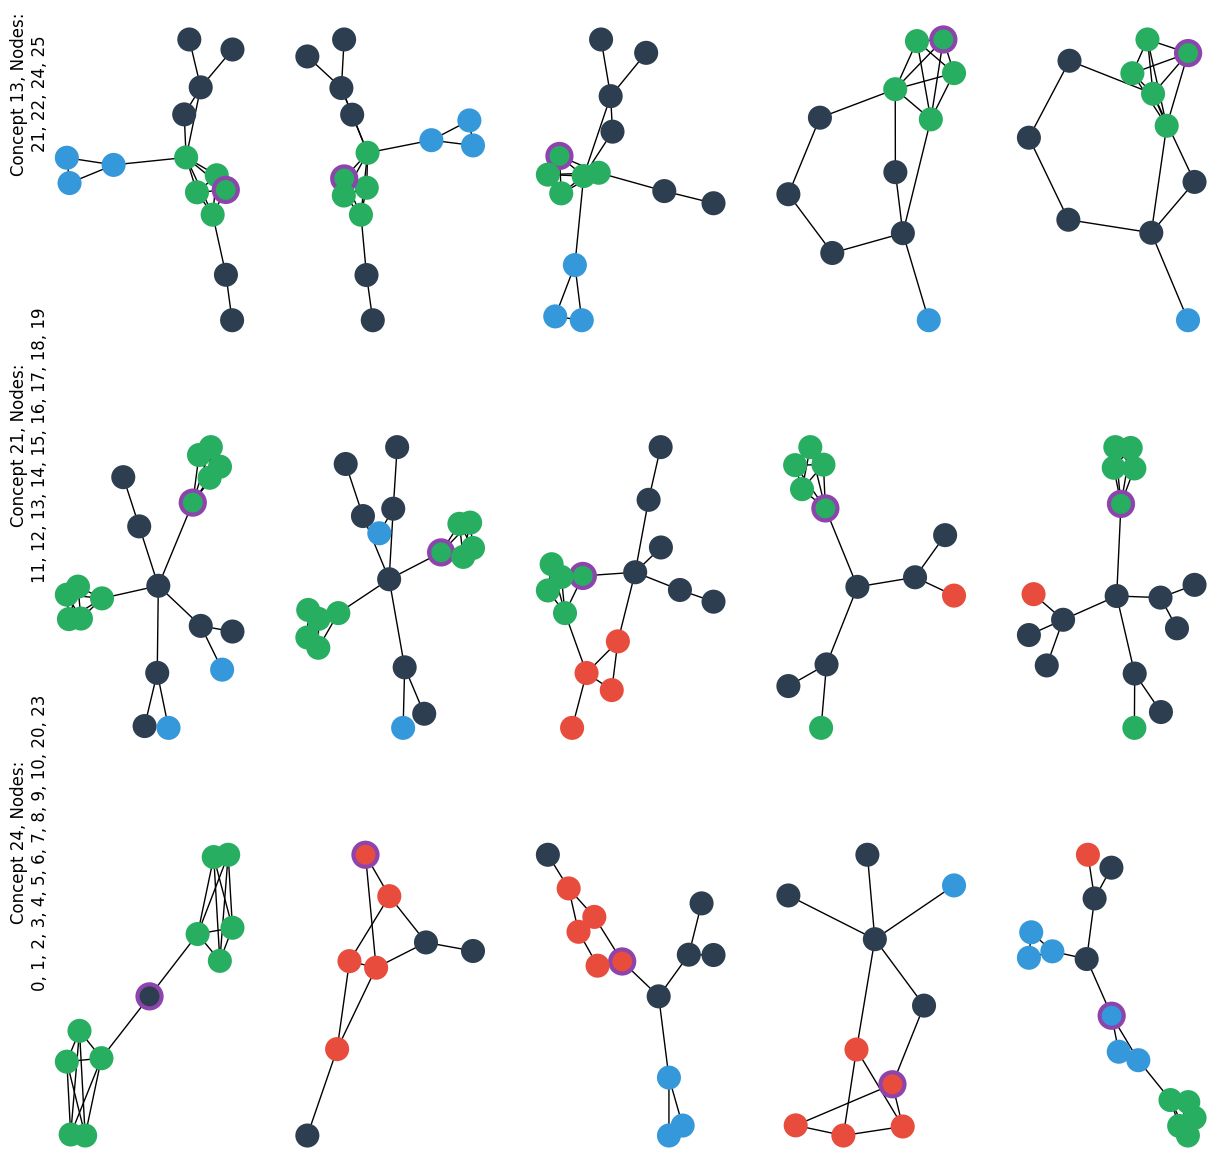

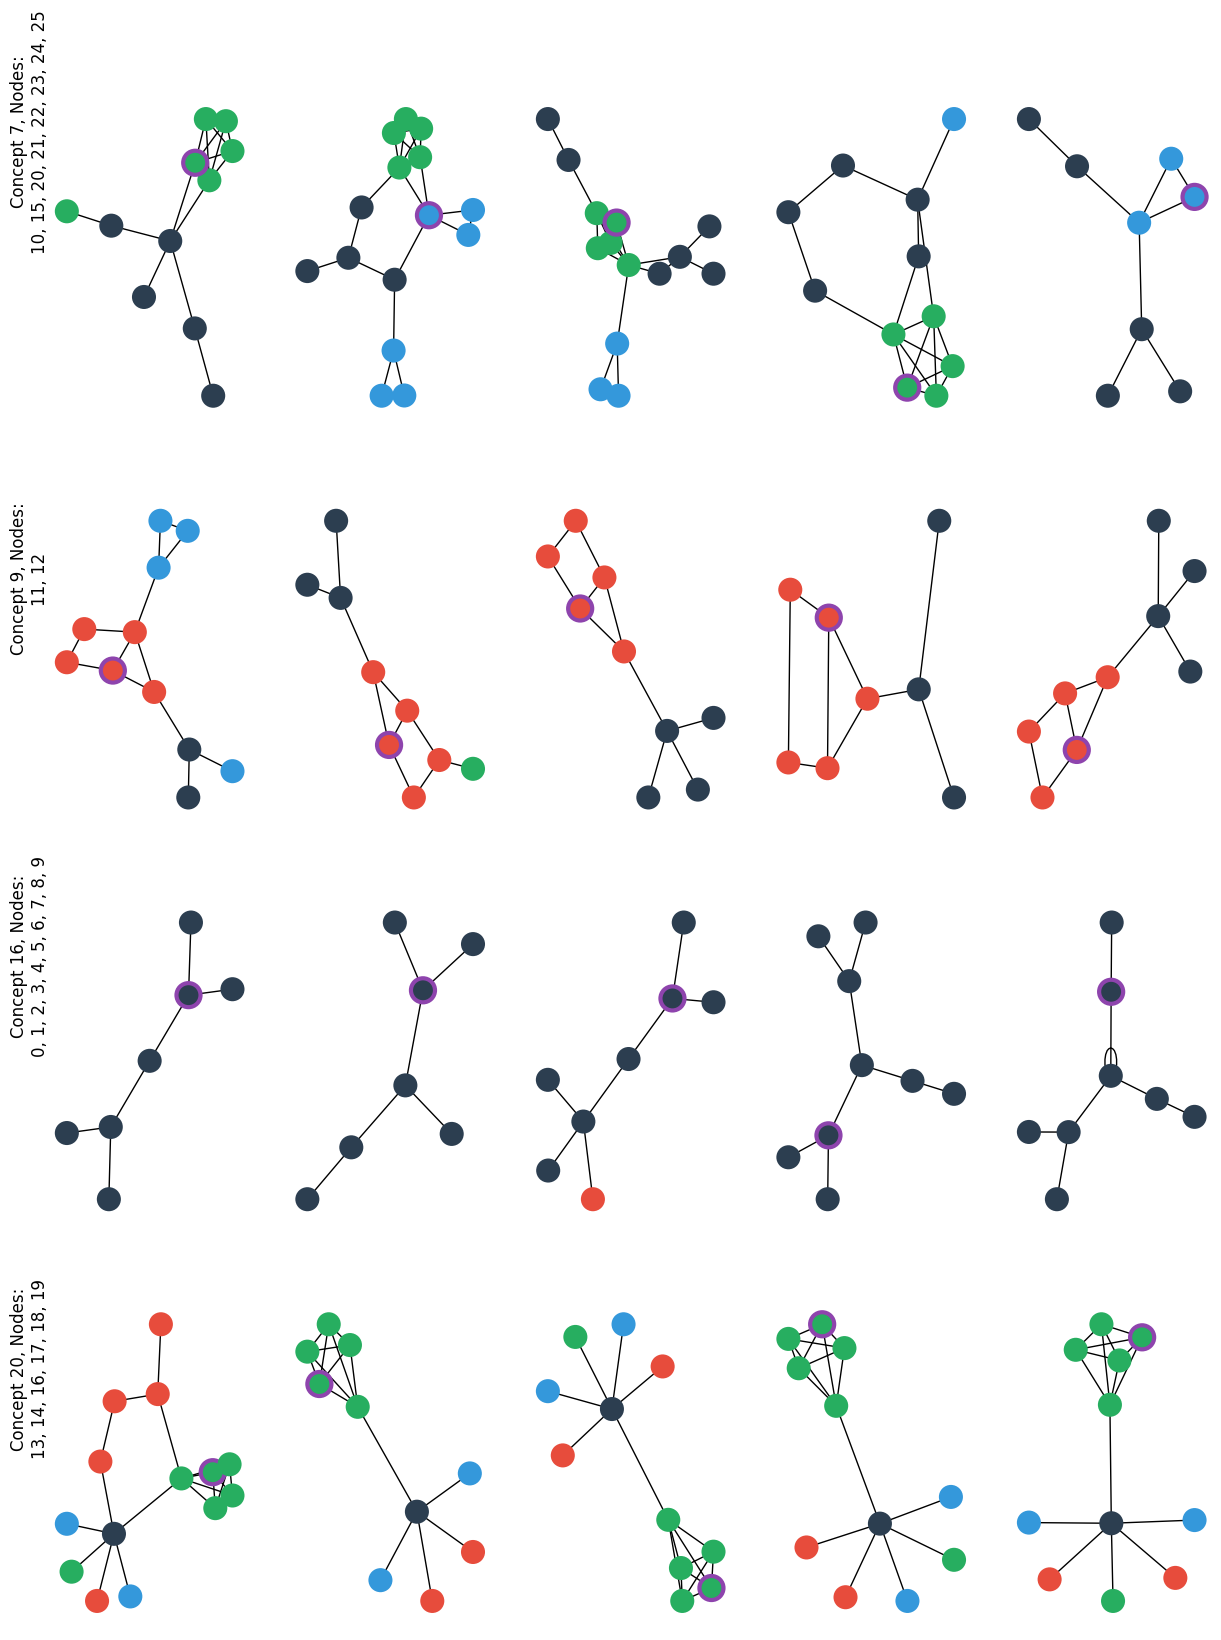

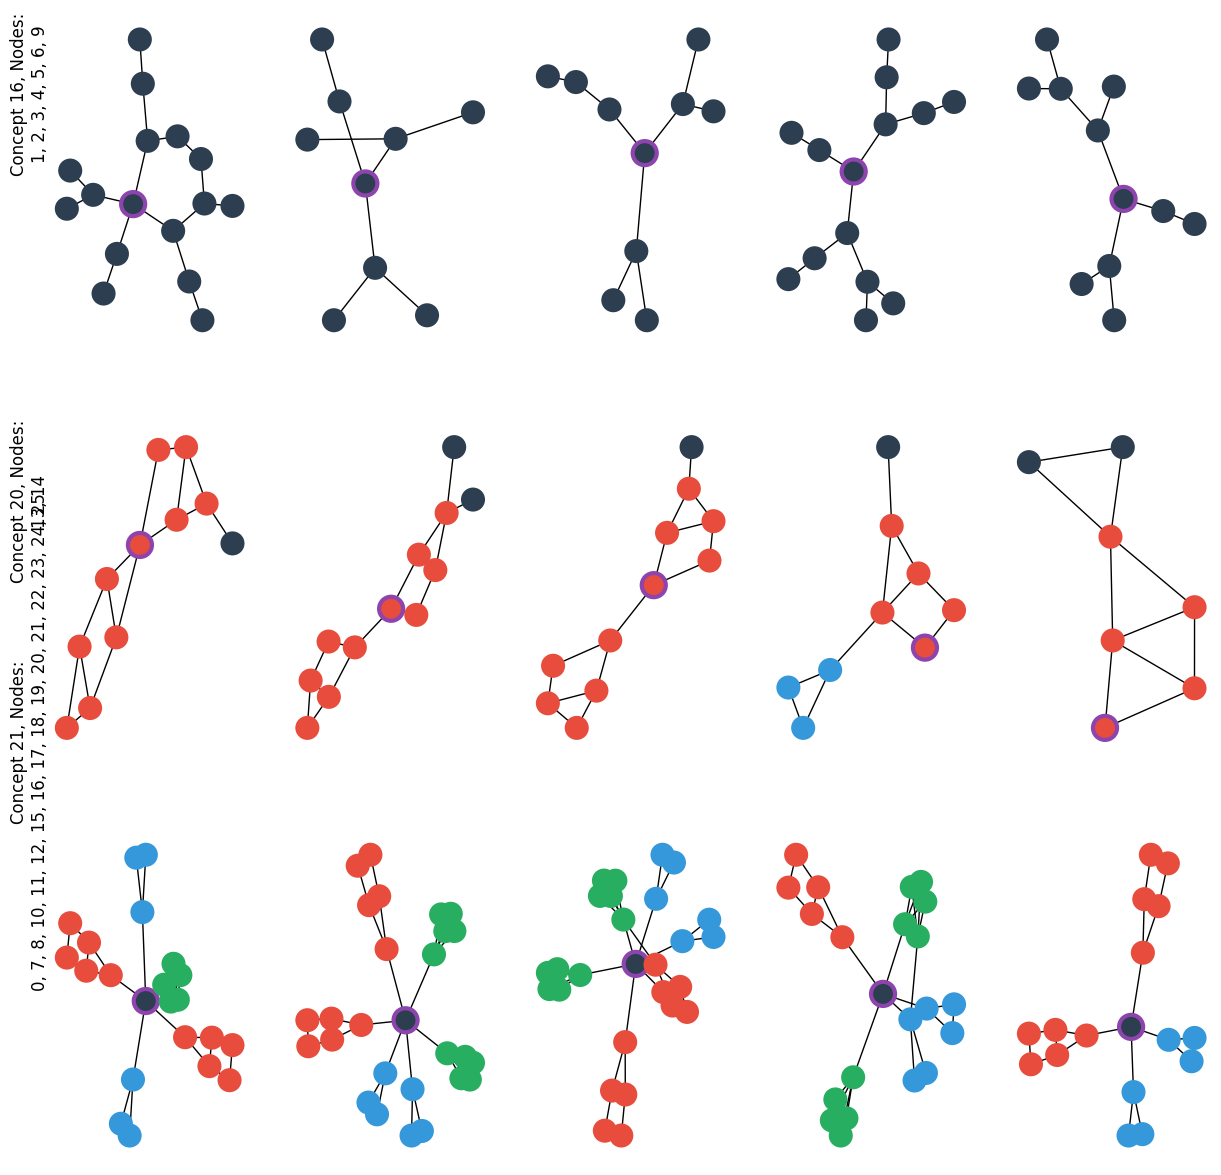

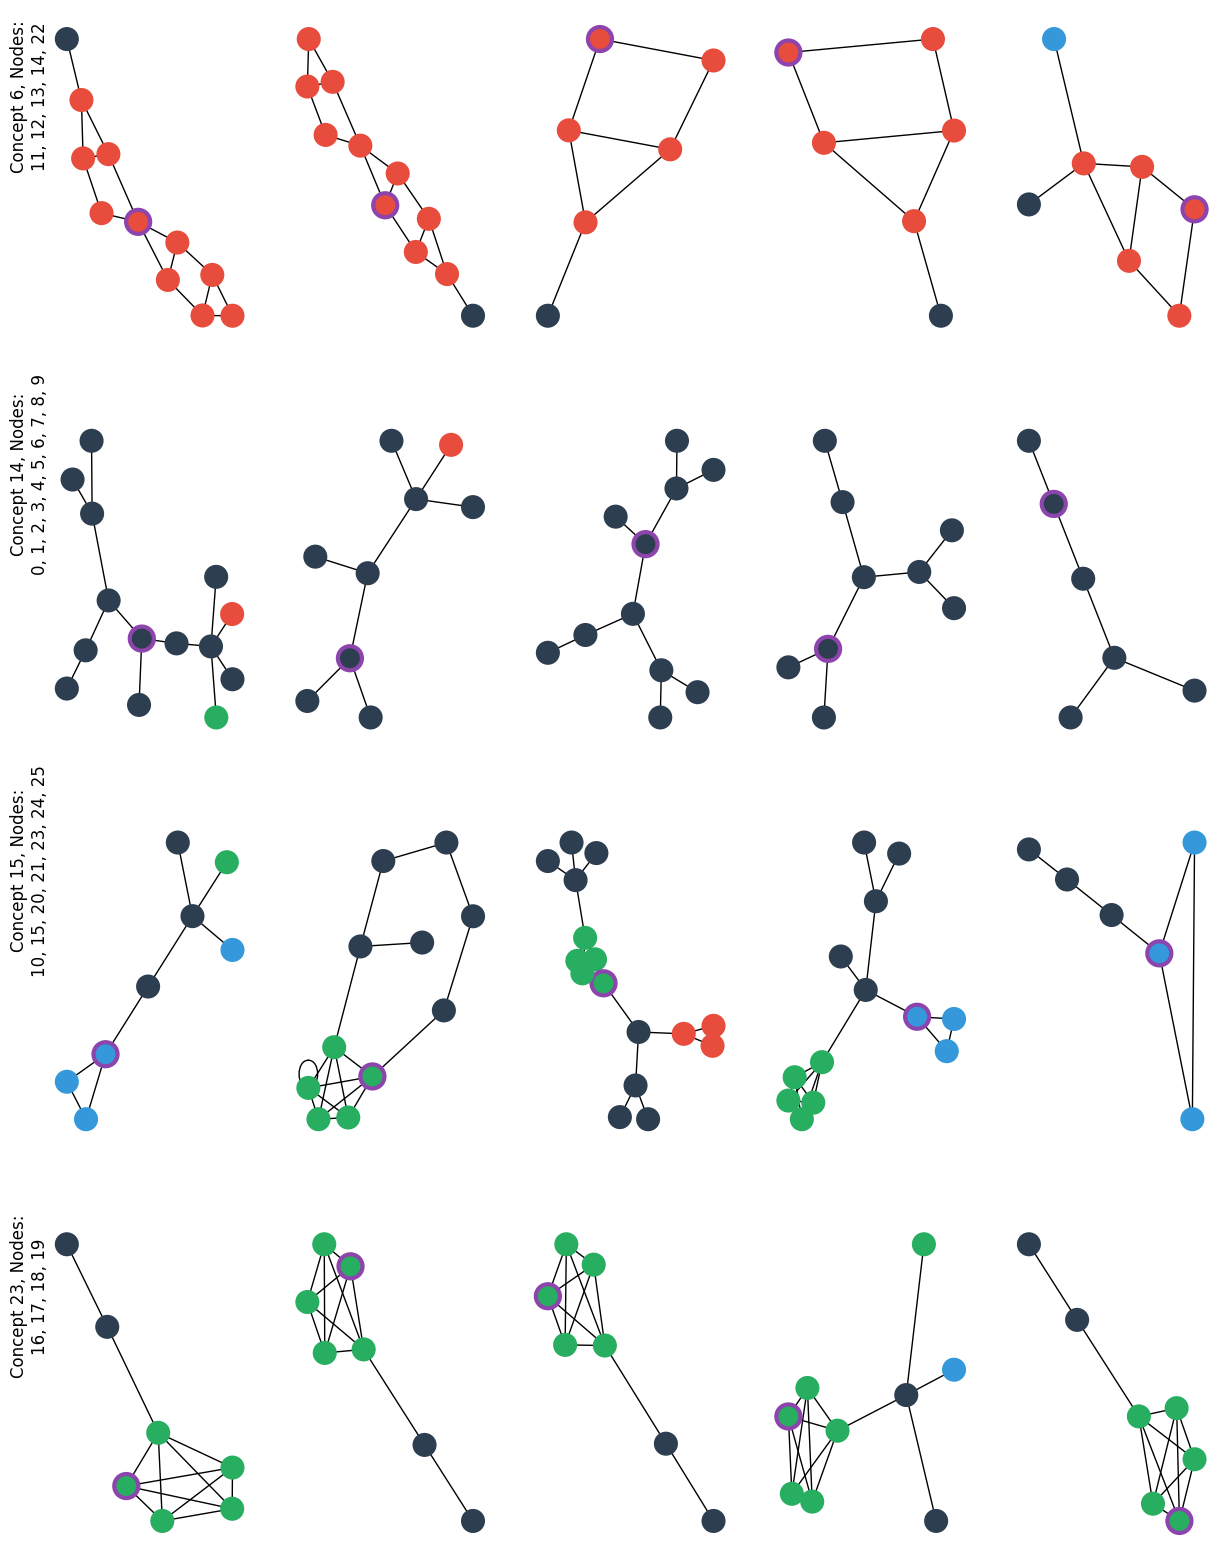

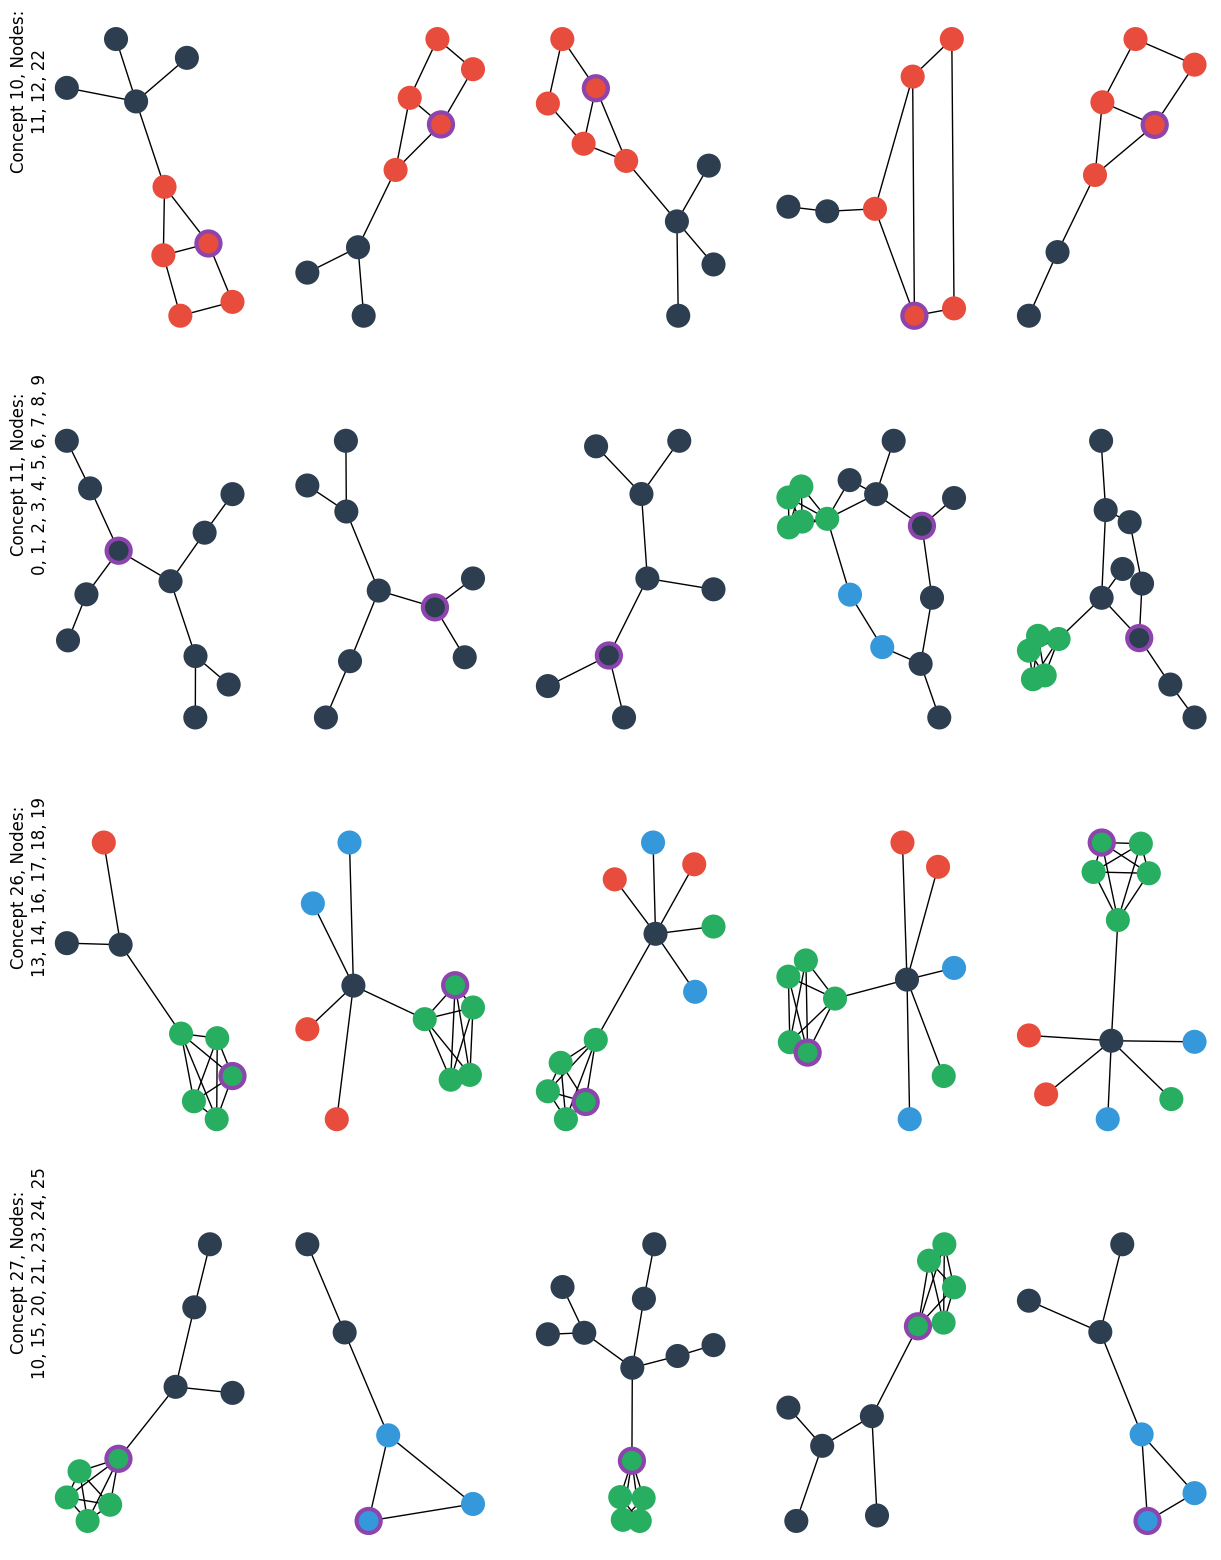

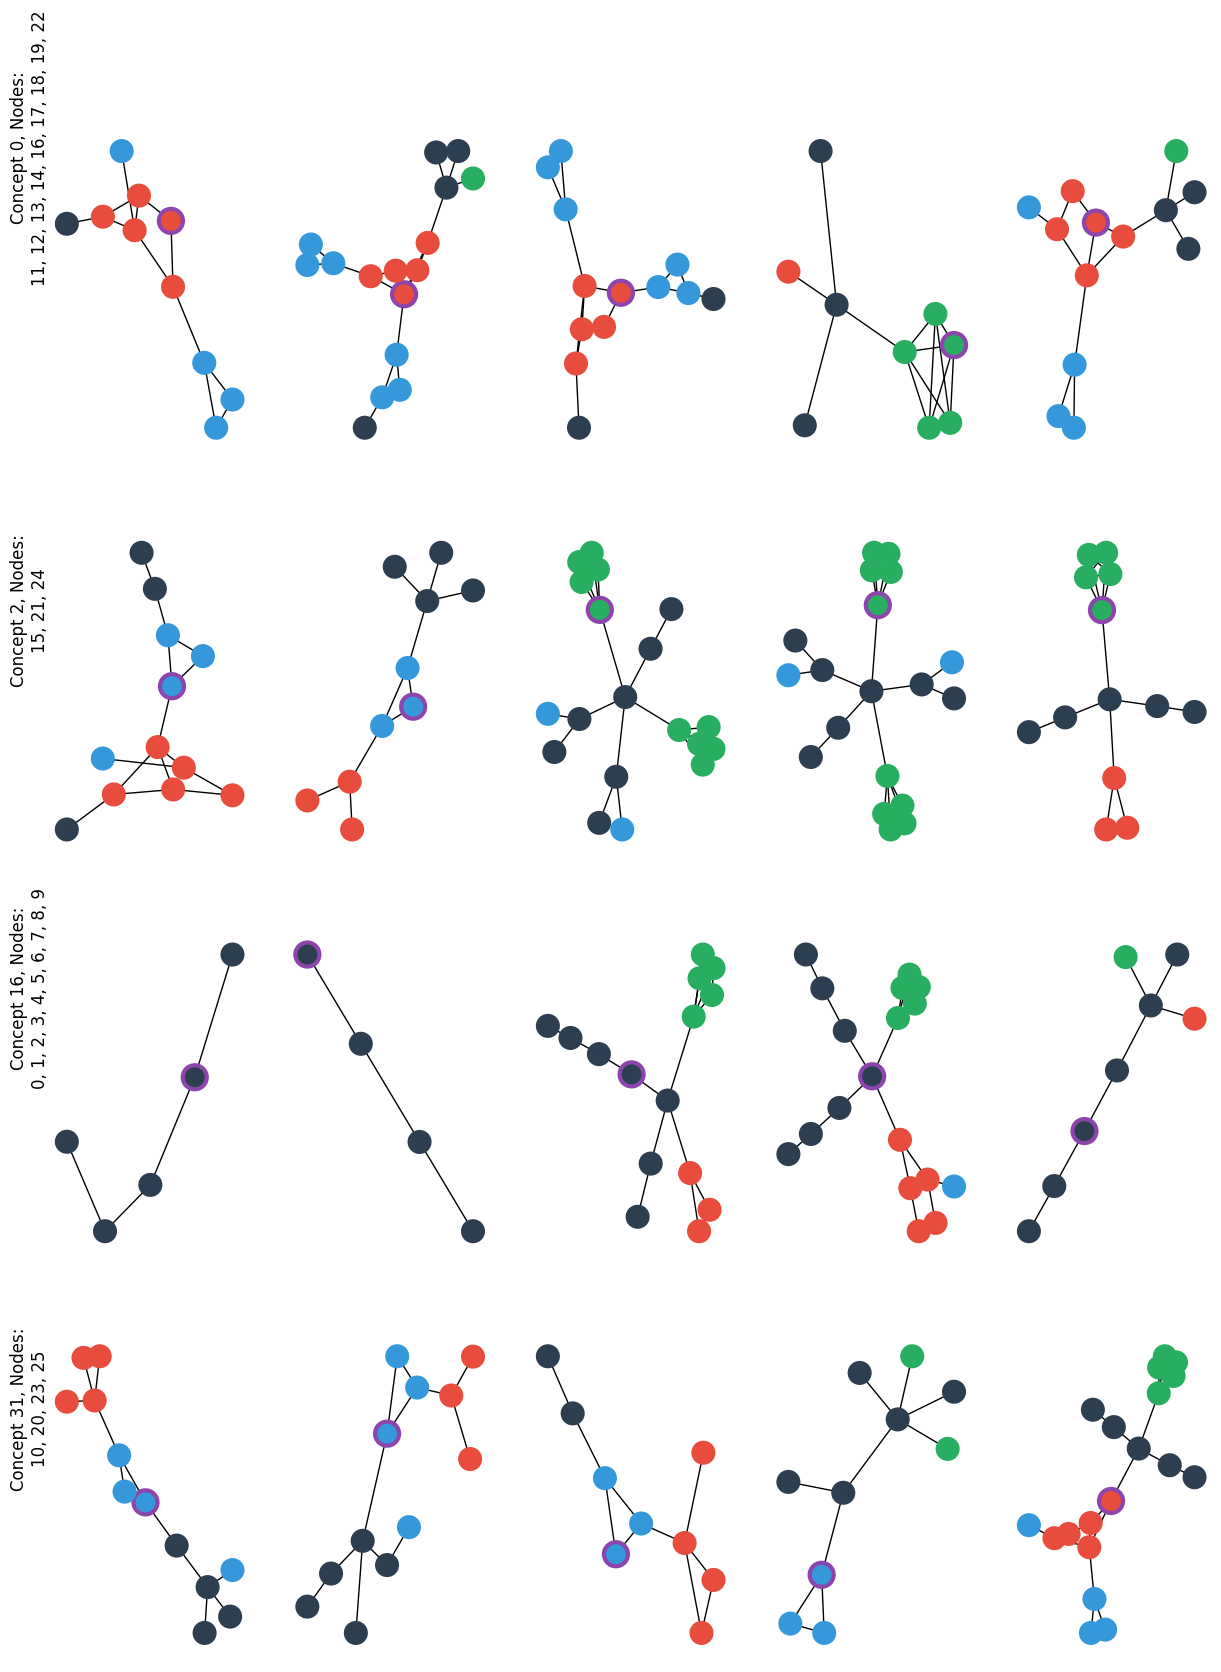

In [16]:
for _, m in models.items():
    _ = m.show_nearest_discretized(sample)

C:\Users\jonas\AppData\Local\Temp\ipykernel_27112\1816248334.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices)


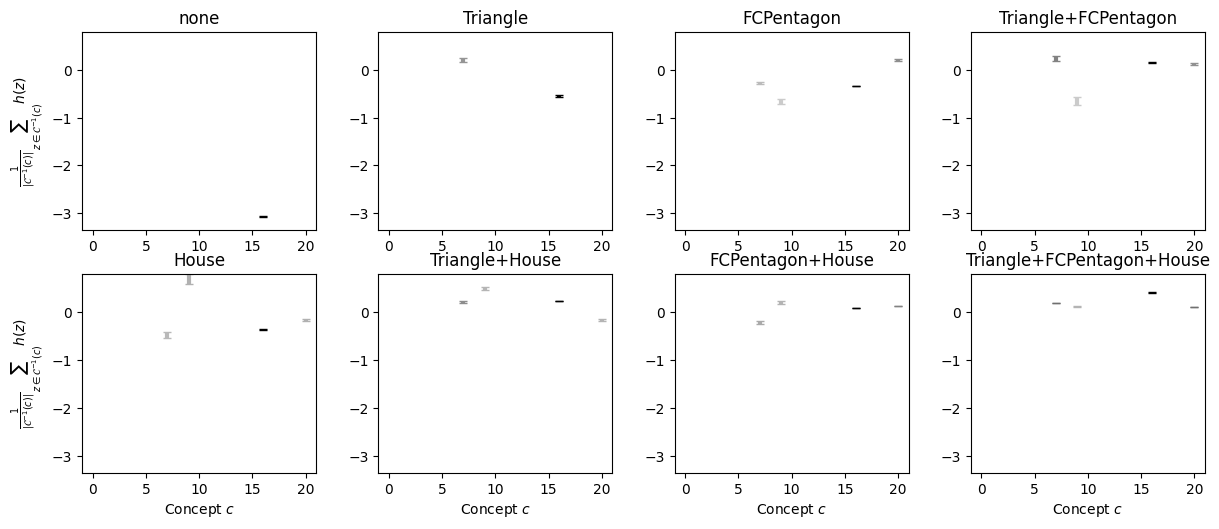

In [74]:
model = models["full"] #gumbel_theta0_reconst0
from torch_scatter import scatter
def _scatter_mean_and_std(values, indices):
    # [num_nodes, k]
    values = torch.tensor(values)
    # [num_nodes]
    indices = torch.tensor(indices)
    # [num_unique_indices, k]
    mean = scatter(values, indices, dim=0, reduce="mean")
    squared_diff = torch.square(values - mean[indices])
    squared_diff_sums = scatter(squared_diff, indices, dim=0, reduce="sum")
    n = scatter(torch.ones_like(values), indices, dim=0, reduce="sum")
    std = torch.sqrt(squared_diff_sums / (n - 1))
    return mean.detach().numpy(), std.detach().numpy()

def plot_average_h(self, save_path=None):
    fig, ax = plt.subplots()
    fig.tight_layout()
    counts = np.bincount(np.argmax(self.x_out_all, axis=1))
    ax_counts = ax.twinx()
    ax_counts.bar(np.arange(counts.shape[0]), counts, alpha=0.4)
    ax_counts.set_ylabel("$|\mathcal{C}^{-1}(c)|$") #  (number of nodes categorized as $c$)

    concepts = torch.tensor(np.argmax(self.x_out_all, axis=1))
    # [num_concepts, 1], [num_concepts, 1]
    mean_h, std_h = _scatter_mean_and_std(self.h_all, concepts)

    ax.errorbar(np.arange(mean_h.shape[0]), mean_h.squeeze(1), std_h.squeeze(1), linestyle='None', marker="o", color="black")
    ax.set_xlabel("Concept $c$")
    ax.set_ylabel("$\\frac{1}{|\mathcal{C}^{-1}(c)|}\sum_{z\in\mathcal{C}^{-1}(c)} h(z)$")

    if save_path is not None:
        fig.savefig(save_path)
    return fig

def plot_average_theta_and_h(self, save_path=None, num_rows=2):
    num_cols = (self.out_all.shape[1] + 1) // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5))
    # axes = list(axes[0]) + list(axes[1])
    fig.tight_layout()
    num_classes = self.out_all.shape[1]
    num_concepts = self.x_out_all.shape[1]

    concepts = torch.tensor(np.argmax(self.x_out_all, axis=1))

    # [num_concepts, num_classes], [num_concepts, num_classes]
    mean_theta, std_theta = _scatter_mean_and_std(self.theta_all, concepts)

    min_val = np.min(mean_theta) - np.max(std_theta)
    max_val = np.max(mean_theta) + np.max(std_theta)
    for r in range(num_rows):
        axes[r][0].set_ylabel("$\\frac{1}{|\mathcal{C}^{-1}(c)|}\sum_{z\in\mathcal{C}^{-1}(c)} h(z)$")
        for c in range(min(num_cols, num_classes - r * num_cols)):
            i = r * num_cols + c
            # [num_concepts]
            counts = np.bincount(np.argmax(self.x_out_all[self.y_all[self.batch_all] == i], axis=1), minlength=num_concepts)
            counts = counts / np.max(counts)
            colors = np.zeros((num_concepts, 3))
            colors[:, :] = np.where(counts[:, None] == 0, 1, 0.8 * np.sqrt(1 - counts[:, None]))

            axes[r][c].set_title(self.dataset_wrapper.class_names[i])#.replace("+", "+\n"))
            for j in range(mean_theta.shape[0]):
                axes[r][c].errorbar(j, mean_theta[j, i], std_theta[j, i], linestyle='None', color=colors[j, :], ecolor=colors[j, :], capsize=3, elinewidth=3)

            # axes[r][c].errorbar(np.arange(mean_theta.shape[0]), mean_theta[:, i], std_theta[:, i], linestyle='None', marker="o", ecolor=colors, capsize=5) # cmap="Greys"
            # axes[r][c].scatter(np.arange(mean_theta.shape[0]), mean_theta[:, i], linestyle='None',  c=counts, cmap="Greys")

            # ax_counts = axes[r][c].twinx()
            # ax_counts.bar(np.arange(counts.shape[0]), 100*counts, alpha=0.4)

            axes[r][c].set_ylim([min_val, max_val])
            if r == num_rows - 1:
                axes[r][c].set_xlabel("Concept $c$")
        # ax_counts.set_ylabel("$|\mathcal{Z}(c)|$")

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    return fig

_ = plot_average_theta_and_h(model, save_path="avg_theta_h.pdf")

In [75]:
def plot_node_dropout(self: InterpretationData, save_path=None, num_rows=2):
    num_classes = self.out_all.shape[1]
    num_graphs = self.out_all.shape[0]
    num_concepts = self.x_out_all.shape[1]
    num_cols = (num_classes + 1) // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))

    concepts = torch.tensor(np.argmax(self.x_out_all, axis=1))
    prediction_diffs = np.empty((num_concepts, num_graphs, num_classes))
    def prep(t, mask):
        return torch.tensor(t[mask], device=self.device)
    with torch.no_grad():
        for i in range(num_concepts):
            mask = concepts != i
            out, theta, h = self.model.pooling_layer(prep(self.x_out_all, mask), prep(self.batch_all, mask), None)
            prediction_diffs[i, :, :] = torch.softmax(out, dim=-1).detach().cpu().numpy()

    prediction_diffs -= torch.softmax(torch.tensor(self.out_all), dim=-1).numpy()[None, :, :]
    prediction_diffs *= 100

    for r in range(num_rows):
        for c in range(min(num_cols, num_classes - num_cols * r)):
            i = r * num_cols + c

            counts = np.bincount(np.argmax(self.x_out_all[self.y_all[self.batch_all] == i], axis=1), minlength=num_concepts)
            counts = counts / np.max(counts)
            colors = np.zeros((num_concepts, 3))
            colors[:, :] = np.where(counts[:, None] == 0, 1, 0.8 * np.sqrt(1 - counts[:, None]))

            container = axes[r][c].bar(np.arange(num_concepts), np.mean(prediction_diffs[:, :, i], axis=1), yerr=np.std(prediction_diffs[:, :, i], axis=1), color=colors, error_kw=dict(lw=1, capsize=0, capthick=0))

            # Color error bars
            connector, caplines, (vertical_lines,) = container.errorbar.lines
            vertical_lines.set_color(colors)

            axes[r][c].axhline(y=0, color='black', linestyle='-')



    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    return fig

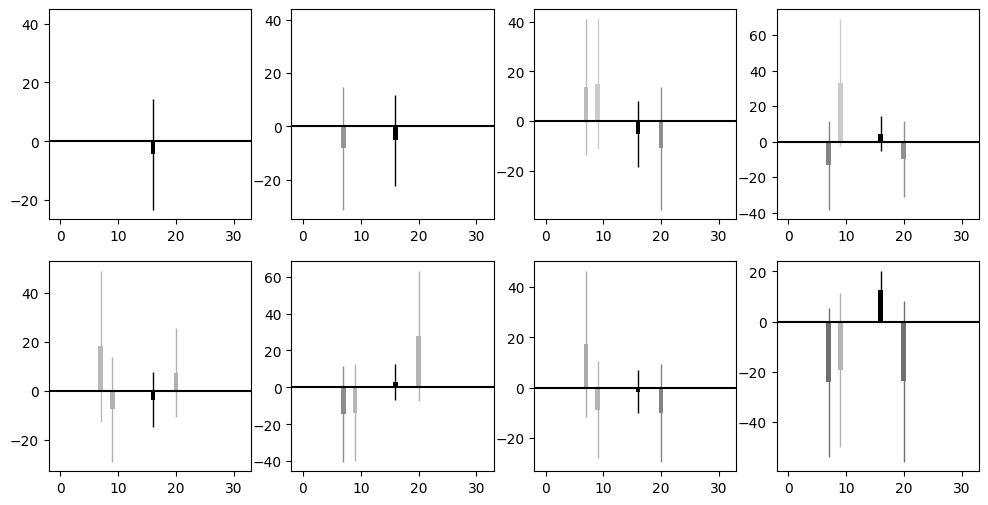

In [76]:
_ = plot_node_dropout(model)

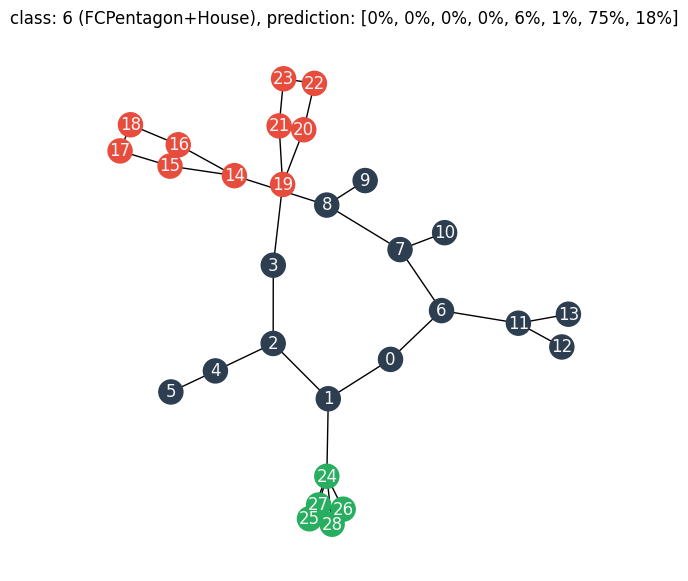

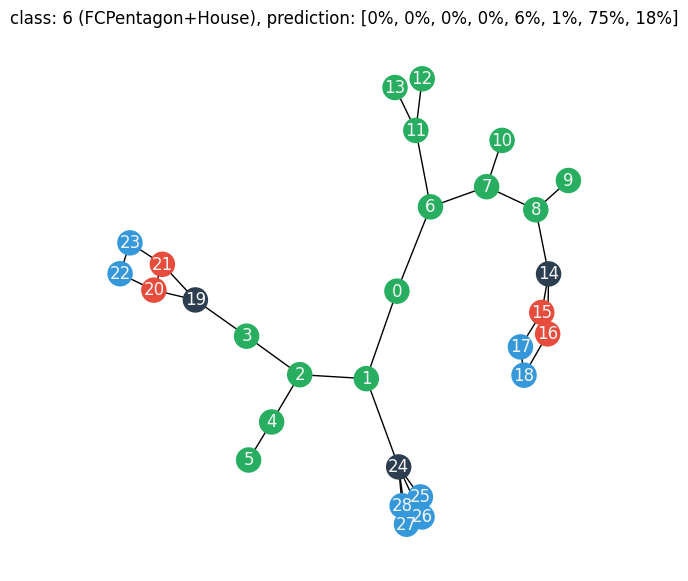

In [55]:
sample = 16
_ = model.draw_graph(sample, save_path="vis/gt_graph.pdf")
_ = model.draw_graph(sample, save_path="vis/predicted_graph.pdf", color_concepts=True)

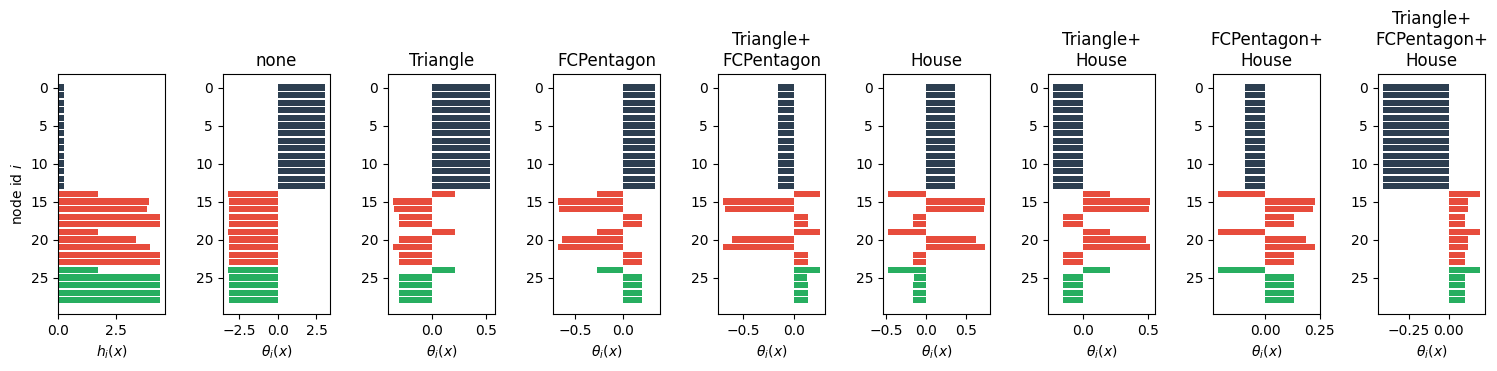

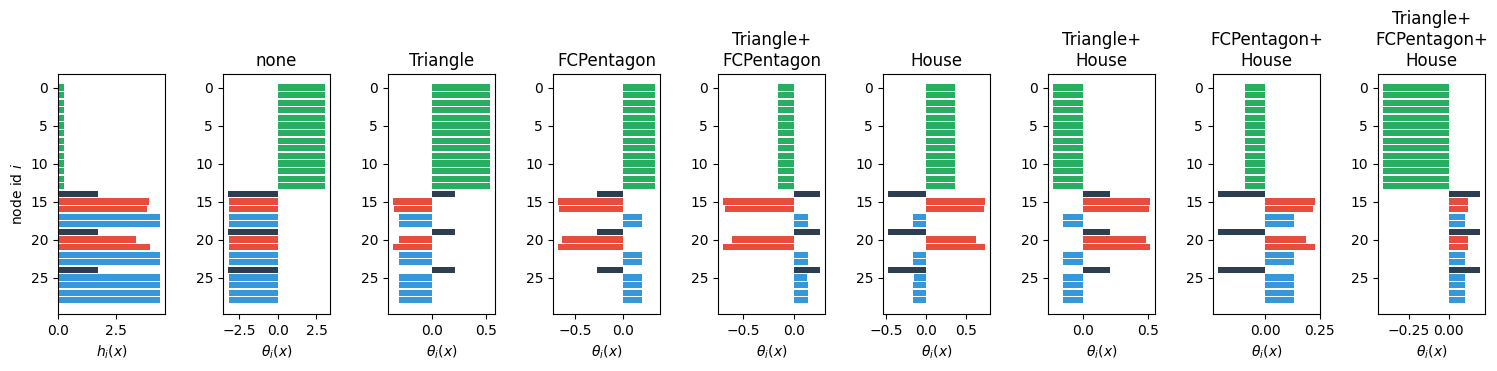

In [50]:
_ = model.plot_theta_and_h(sample, False)
_ = model.plot_theta_and_h(sample, True, save_path="vis/h_theta.pdf")

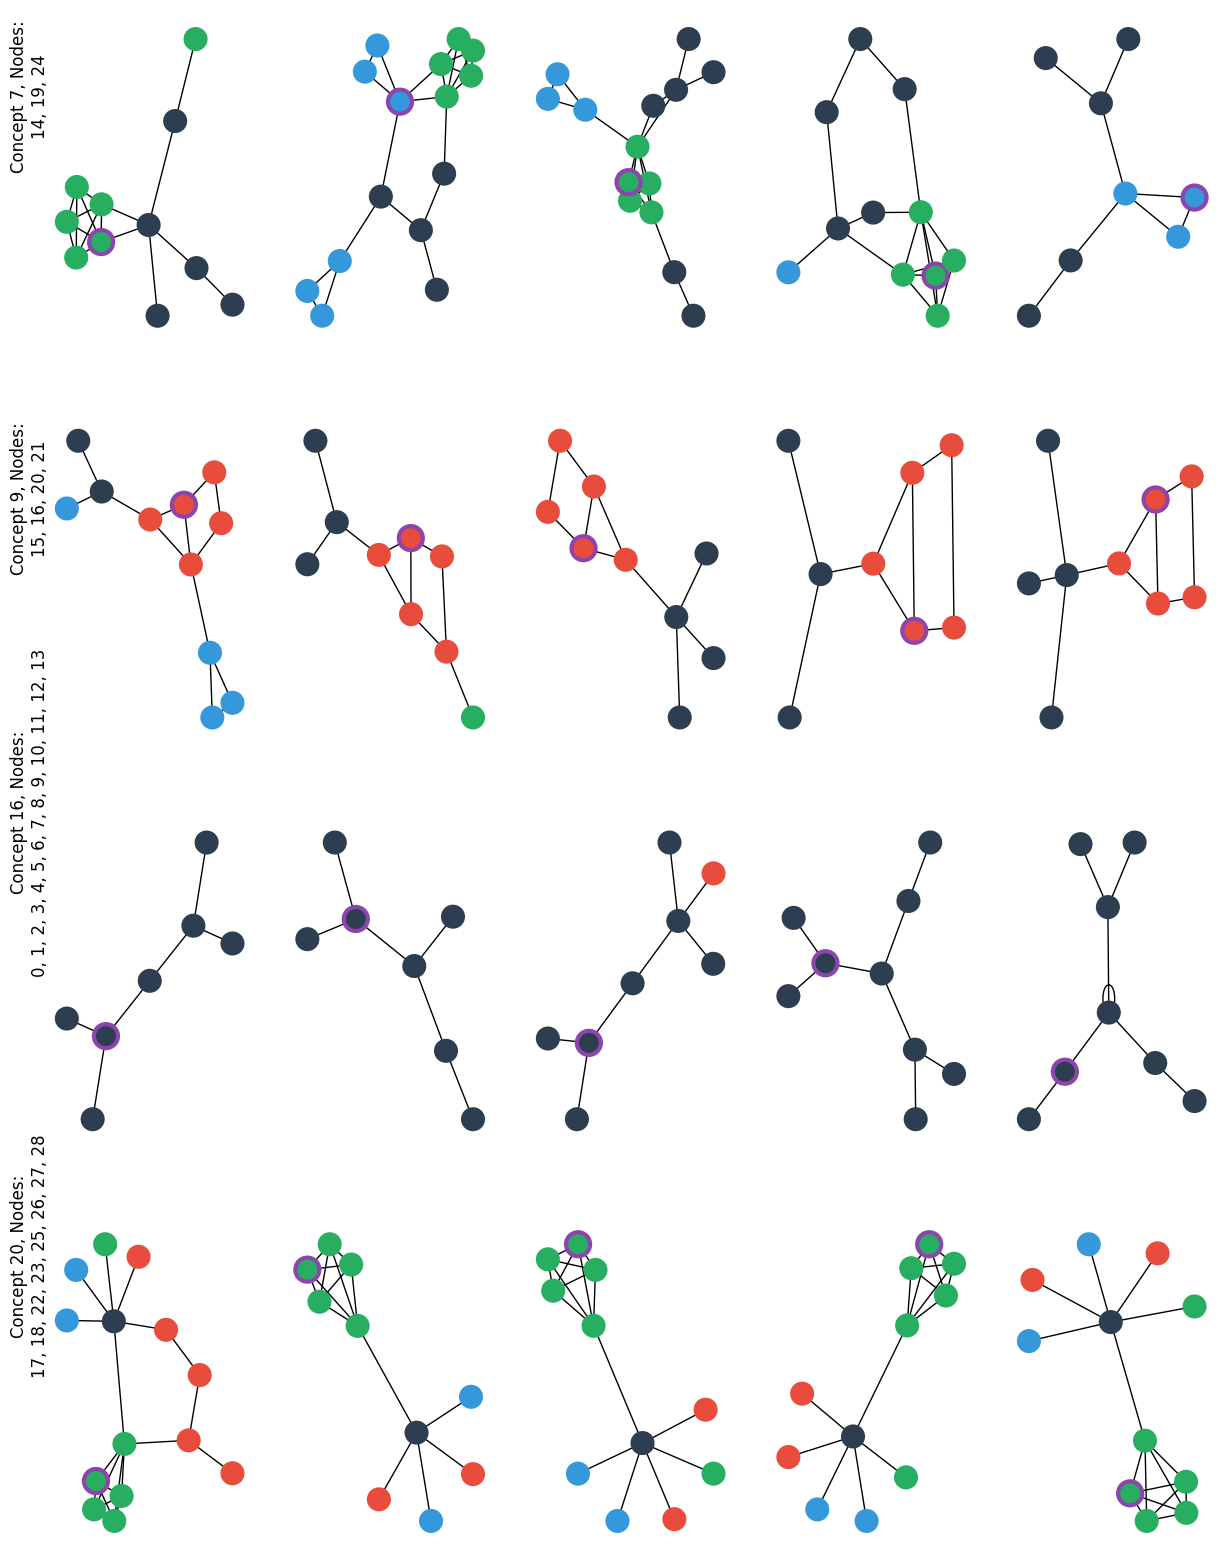

In [40]:
_ = model.show_nearest_discretized(sample, save_path="vis/nearest.pdf")

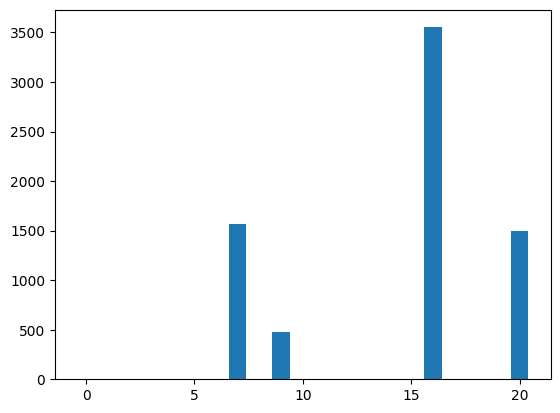

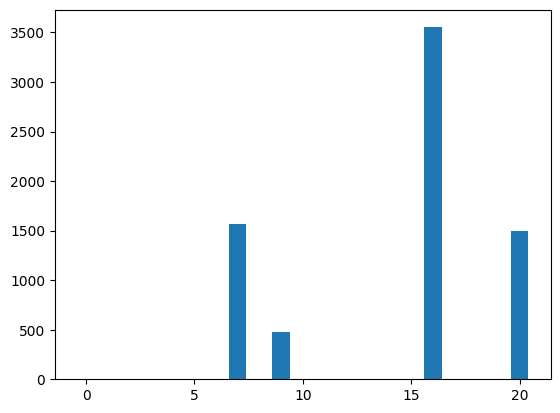

In [49]:
model.plot_category_histogram()